In [1]:

# come il precedente, testato con i dati sono stati presi da
# https://github.com/pynbody/genetic_example/blob/main/tutorial.ipynb

def associate_units_to_center(center_in = None , units_in = None, snap_in=None):

  import pynbody

  if units_in is None:
    # use a standard recentering
    assert snap_in is not None
    center_out = pynbody.array.SimArray(center_in,snap_in.properties['boxsize'])
  else:
    center_out = pynbody.array.SimArray(center_in,units_in)

  return center_out

In [2]:

def center_data(snap = None, center_with_units_in = None):
  '''
  shift the selected data such that center will be in coordinates 0,0,0
  '''
  
  import numpy as np

  for tipo in snap.families():
    print(tipo)
    snap[tipo]['pos'] = snap[tipo]['pos']- center_with_units_in[np.newaxis,:]

  return snap

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pynbody
import os, h5py

fold_out      = ".data/out/"             # folder per gli output
size_cut_mpc  = "20 Mpc"                 # size of the field of view to extract
center_cut    = np.array([0.0,0.0,0.0])  # recentering for the data cut, assume it is in unit box


#-----------------------------------------
if not os.path.isdir(fold_out):
  os.mkdir(fold_out)
#-----------------------------------------

# carica i dati
example_snapshot = pynbody.load(".data/step_1_uniform/gadget_output/snapshot_047.hdf5")
example_snapshot.physical_units()

print("avaiable types             ",example_snapshot.families())
print("dm fields can be loaded    ",example_snapshot.dm.loadable_keys())

avaiable types              [<Family dm>]
dm fields can be loaded     ['mass', 'pos', 'eps', 'iord', 'vel']


/home/tmassagl/development/pynbody/.venv/lib/python3.12/site-packages/pynbody/snapshot/gadgethdf.py:449: UserWarning: Masses are either stored in the header or have another dataset name; assuming the cosmological factor h**-1
  warnings.warn("Masses are either stored in the header or have another dataset name; assuming the cosmological factor %s" % units.h**-1)


In [4]:
# prepara un taglio spaziale, sfruttando i filtri di pynbody

# prepara un nuovo centro per i dati
centro_del_taglio = associate_units_to_center(center_in = center_cut, snap_in= example_snapshot)
# sposta lo snapshot al centro del box la regione di interesse
example_snapshot  = center_data(snap=example_snapshot, center_with_units_in = centro_del_taglio)
# prepara una maschera spaziale, una sfera da size_cut_mpc centrata in 0,0,0; notare che ci sono altri tipi di filtri in pynbody.filt, per esempio parallelepipedi (pynbody.filt.Cuboid)
mask_select       = pynbody.filt.Sphere(size_cut_mpc)
# taglia spazialmente lo snapshot con la maschera
snap_select       = example_snapshot[mask_select]

dm


/home/tmassagl/development/pynbody/.venv/lib/python3.12/site-packages/pynbody/snapshot/gadgethdf.py:469: UserWarning: Unable to infer units from HDF attributes
  warnings.warn("Unable to infer units from HDF attributes")


In [5]:
# prepara i dati da scrivere per la materia oscura
# note:
# - probabilmente vi potrebbe convenire fare un ciclo su example_snapshot.dm.loadable_keys(), se volete dumpare tutto quello che si trova nel file originario
# - rispetto al file di Zinnia, qui ho evitato la size, visto che non e' nel file di esempio da gadget che abbiamo usato, e sostutuito density con massa; con un output standard, non si avrebbe questo problema
qt_out_name   = ["pos_x","pos_y","pos_z","massa"]
qt_to_dump    = ["x"    ,"y"    ,"z"    ,"mass" ]
units_to_dump = ["Mpc"  ,"Mpc"  ,"Mpc"  ,"Msol" ]

# dump data as hdf5
f_out = fold_out+"_test_data.hdf5"
print("dump to")
print("  ",f_out)
with h5py.File(f_out, "w") as f:
  for qt,uni,name in zip(qt_to_dump,units_to_dump,qt_out_name):
    xx = np.array(snap_select.dm[qt].in_units(uni))
    print("  ",qt,np.min(xx),np.max(xx),uni,len(xx))
    __ = f.create_dataset(name, data = xx)

print("dump to")
f_out = fold_out+"test_data.ascii"
print("  ",f_out)
# dump data as ascii
with open(f_out, "w") as f:
  x_1 = snap_select.dm["x"].in_units("kpc")
  x_2 = snap_select.dm["y"].in_units("kpc")
  x_3 = snap_select.dm["z"].in_units("kpc")
  x_4 = snap_select.dm["mass"].in_units("Msol")

  f.write("# "+"\t ".join(qt_out_name)+"\n")
  for ii in range(len(x_1)):
    ss = str(x_1[ii])+"\t "+str(x_2[ii])+"\t "+str(x_3[ii])+"\t "+str(x_4[ii])+"\t "+"\n"
    f.write(ss)

dump to
   out/_test_data.hdf5
   x 0.00032560757 74.272125 Mpc 146738
   y 9.021957e-05 74.27212 Mpc 146738
   z 4.3671156e-05 74.27207 Mpc 146738
   mass 7759946000.0 7759946000.0 Msol 146738
dump to
   out/test_data.ascii


show the cutout data


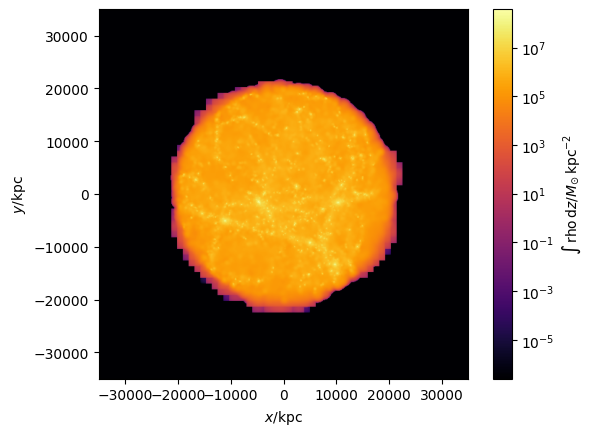

In [6]:

# chiede la creazione di una mappa della colum density del taglio
# operazione un po dirty/nasty, visto che gli abbiamo tagliato via parte dei dati dal cubo originale
print("show the cutout data")
map_out = pynbody.plot.sph.image(
                                   snap_select.dm
                                 , width= "70 Mpc"
                                 , qty="rho"
                                 , av_z=None
                                 , units="Msol kpc^-2"
                                 , resolution= 512
                                 , cmap="inferno",noplot=False
                                 )
plt.show()